# (30) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 3
device = f'cuda:{device_idx}'

## Fit a DeConv model

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jac|deconv')

cfg_vae['n_latents'] = 128
cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 10

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 200
cfg_tr['batch_size'] = 120
cfg_tr['kl_beta'] = 5.0

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [5]:
print(tr.n_iters)

100000

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  559.5 K   |
|     ———     |    ———     |
|  layers.L_0 |  559.5 K   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_t-10_z-[128]_k-32_<jac|deconv>
mc_b120-ep200-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_02,01:04)

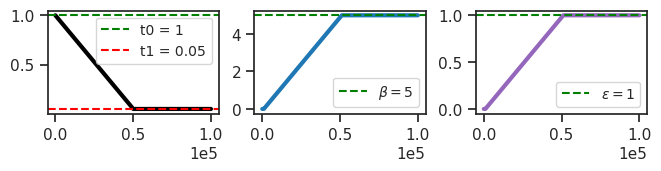

In [6]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [8]:
print_num_params(vae.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  559.5 K   |
|     ———      |    ———     |
|    fc_dec    |  262.1 K   |
|     dec      |  297.1 K   |
+--------------+------------+

In [7]:
print(vae.input_layer.dec)

Sequential(
  (0): UnFlatten()
  (1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): SiLU(inplace=True)
  (3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (4): SiLU(inplace=True)
  (5): ConvTranspose2d(32, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (6): SiLU(inplace=True)
  (7): ConvTranspose2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [9]:
tr.train(fit_name = f"DeConv_{tr.cfg.name()}")

epoch # 200, avg loss: 16.372229: 100%|██████████████████████████████████████████████████████| 200/200 [22:59:43<00:00, 413.92s/it]


## Fit a $T = 2$ model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jac|lin')

cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 2

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 1800
cfg_tr['batch_size'] = 500
cfg_tr['kl_beta'] = 1.0
cfg_tr['kl_balancer'] = None

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'enc_type': 'jac', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.01, 'seq_len': 2}

Trainer:
{'batch_size': 500, 'epochs': 1800, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 'kl_const_portion': 
0.0, 'lr': 0.002, 'kl_beta': 1.0, 'kl_balancer': None}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  132.1 K   |
|     ———     |    ———     |
|  layers.L_0 |  132.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-2_z-[512]_k-32_<jac|lin>
mc_b500-ep1800-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_31,06:59)

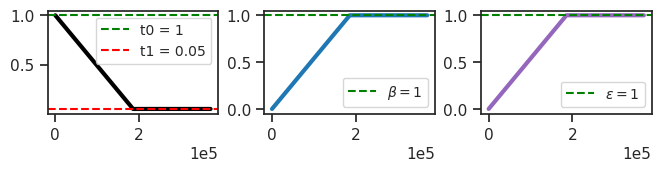

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  132.1 K   |
|     ———      |    ———     |
|    fc_dec    |  131.1 K   |
+--------------+------------+

### Fit model

In [7]:
tr.train(fit_name = f"dMSE_+Bias_bal-{tr.cfg.kl_balancer}_{tr.cfg.name()}")

epoch # 1800, avg loss: 145.828962: 100%|████████████████████████████████████████████████████| 1800/1800 [2:43:26<00:00,  5.45s/it]


In [8]:
print(tr.model.input_layer)

PoissonLayer(dim=512, input_dim=16, temp=0.05, n_exp=62, beta=1, eps=1)

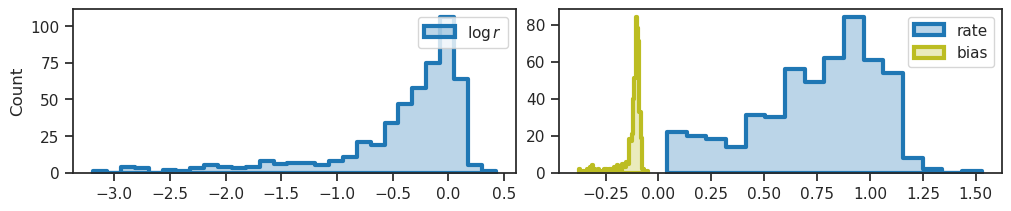

In [9]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
# log_gain = tonp(tr.model.input_layer.log_gain).ravel()
bias = tonp(tr.model.input_layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)
# sns.histplot(log_gain, color='C6', element='step', label=r'$\log g$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
# sns.histplot(np.exp(log_gain), color='C6', element='step', label='gain', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

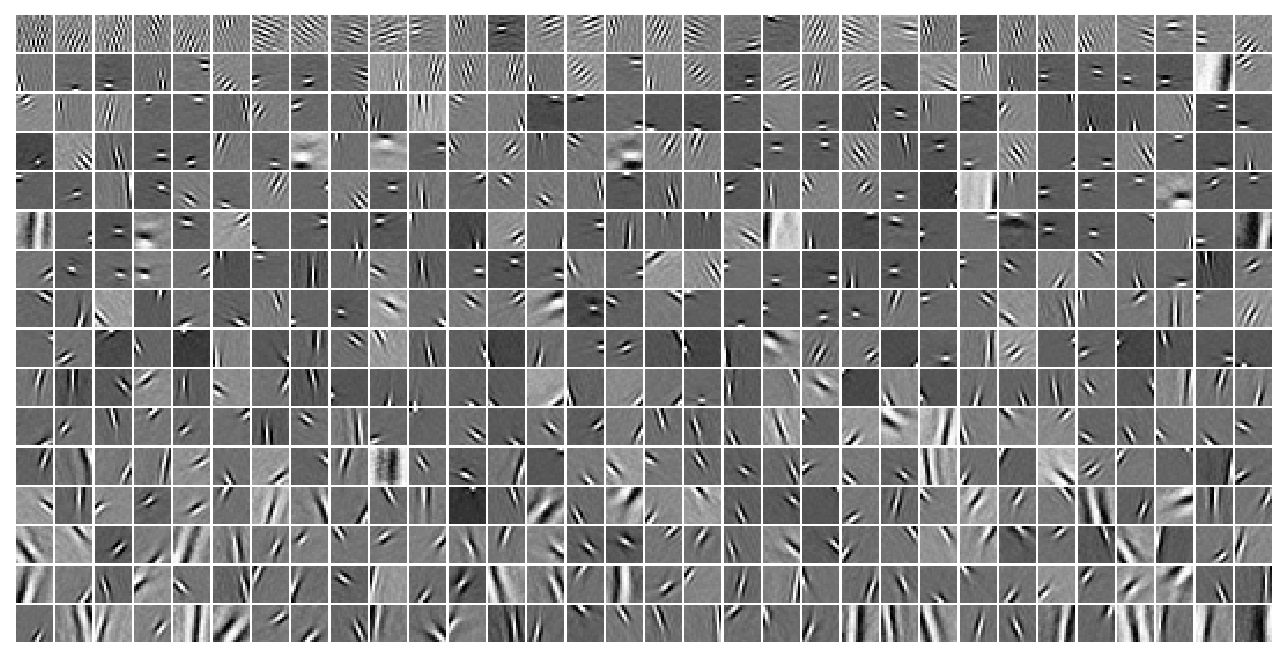

In [13]:
tr.model.show('dec', order=np.argsort(log_rate));

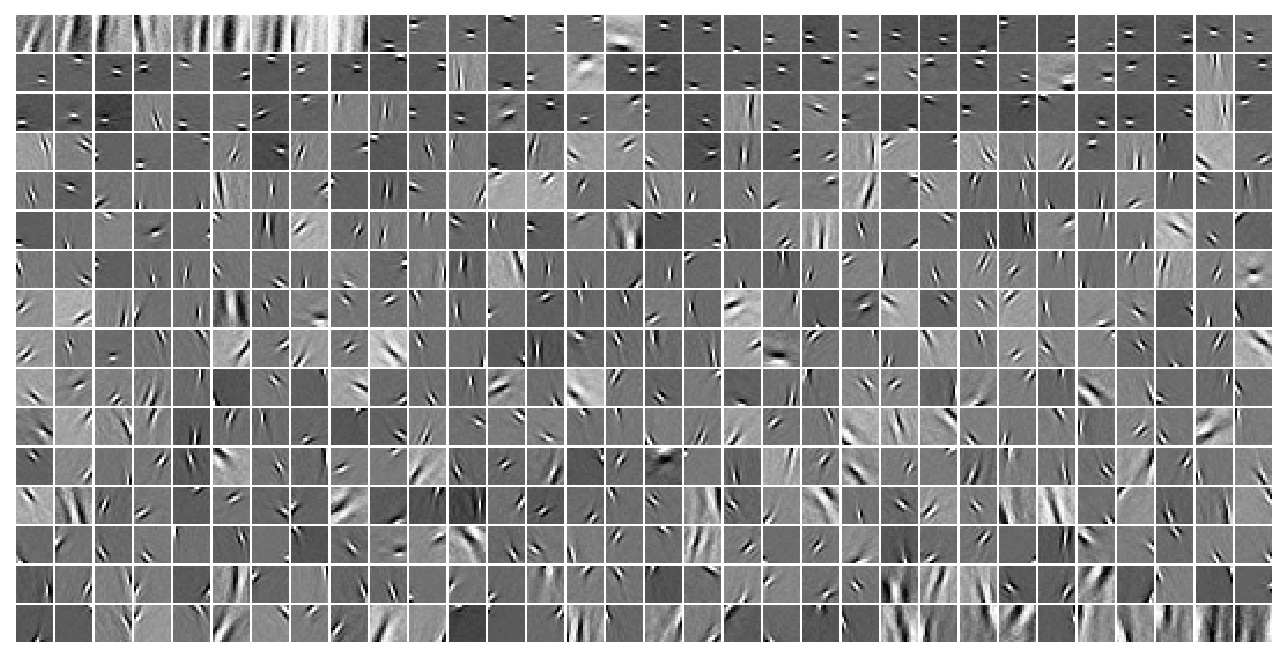

In [11]:
## Was: T = 5, beta = 5.0

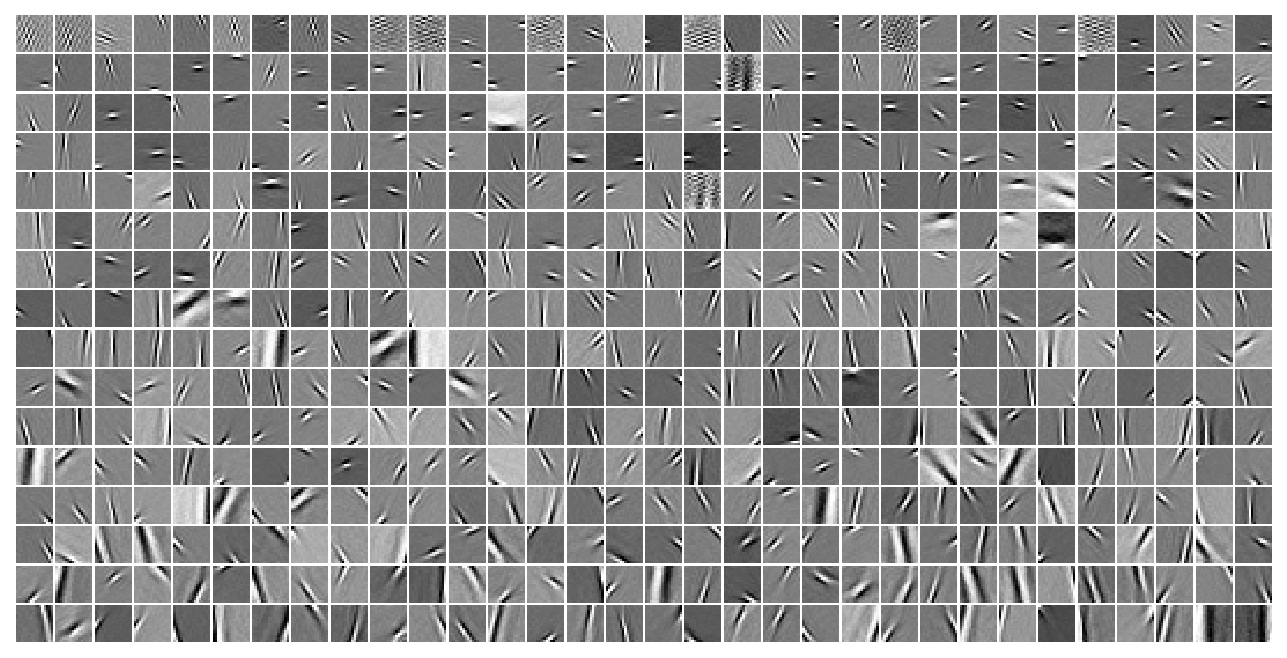

In [12]:
## Was: beta = 3.0

In [10]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{
    'kl': array([27.218367, 20.681807], dtype=float32),
    'recon': array([143.4424  , 106.076515], dtype=float32),
    'nelbo': array([170.6607  , 126.758125], dtype=float32)
}

### Analysis

In [11]:
results = tr.analysis(2000, verbose=True)

100%|█████████████████████████████████| 52/52 [05:12<00:00,  6.01s/it]


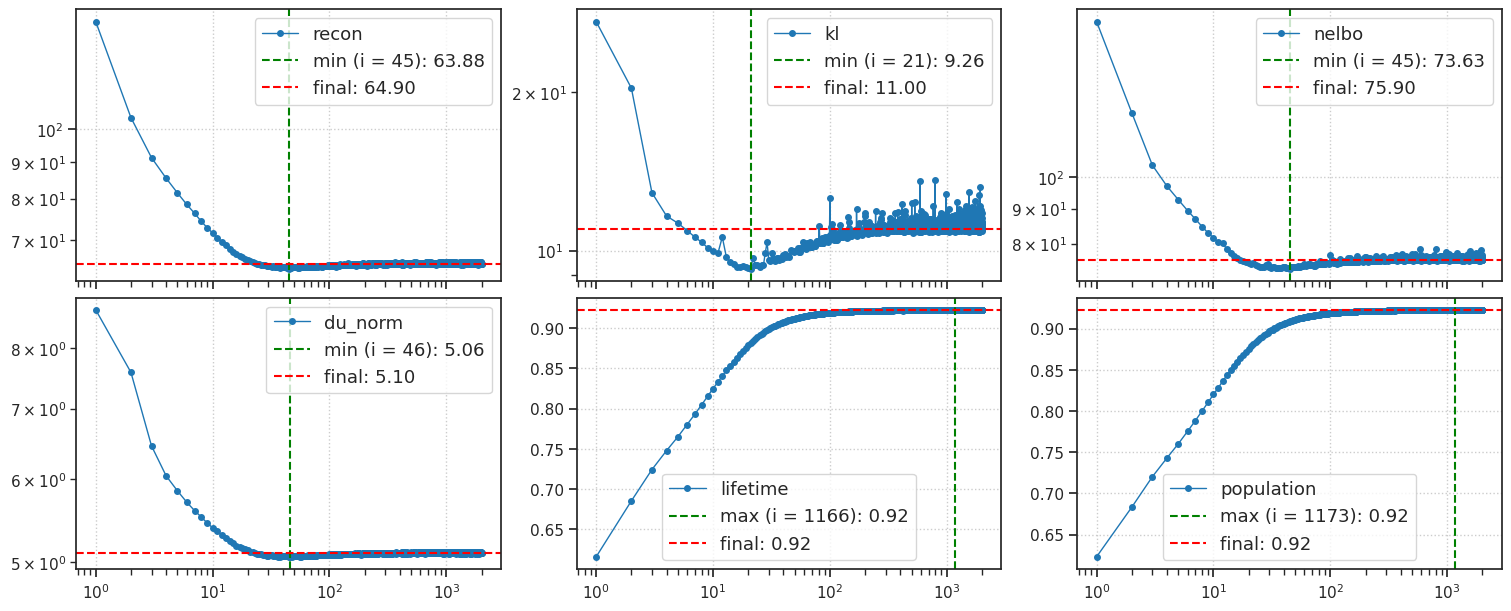

In [12]:
from figures.analysis import plot_convergence
plot_convergence(results)

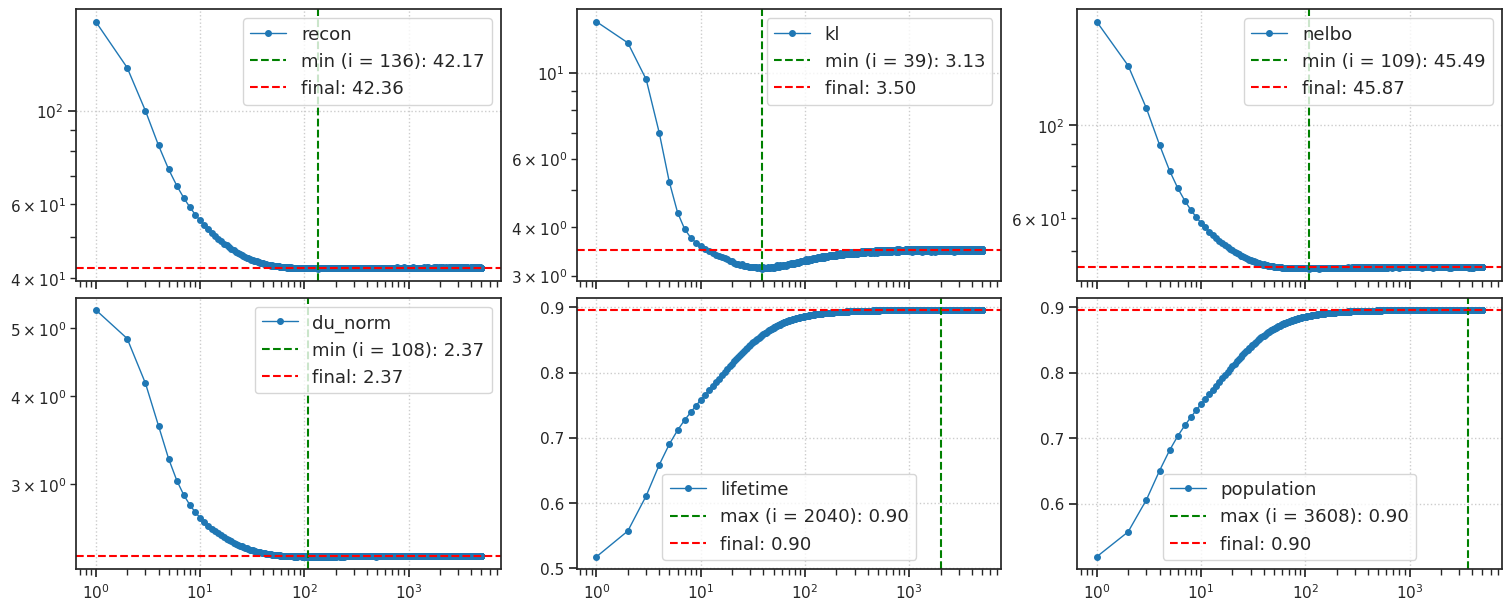

In [14]:
## Was: T = 5, beta = 5.0

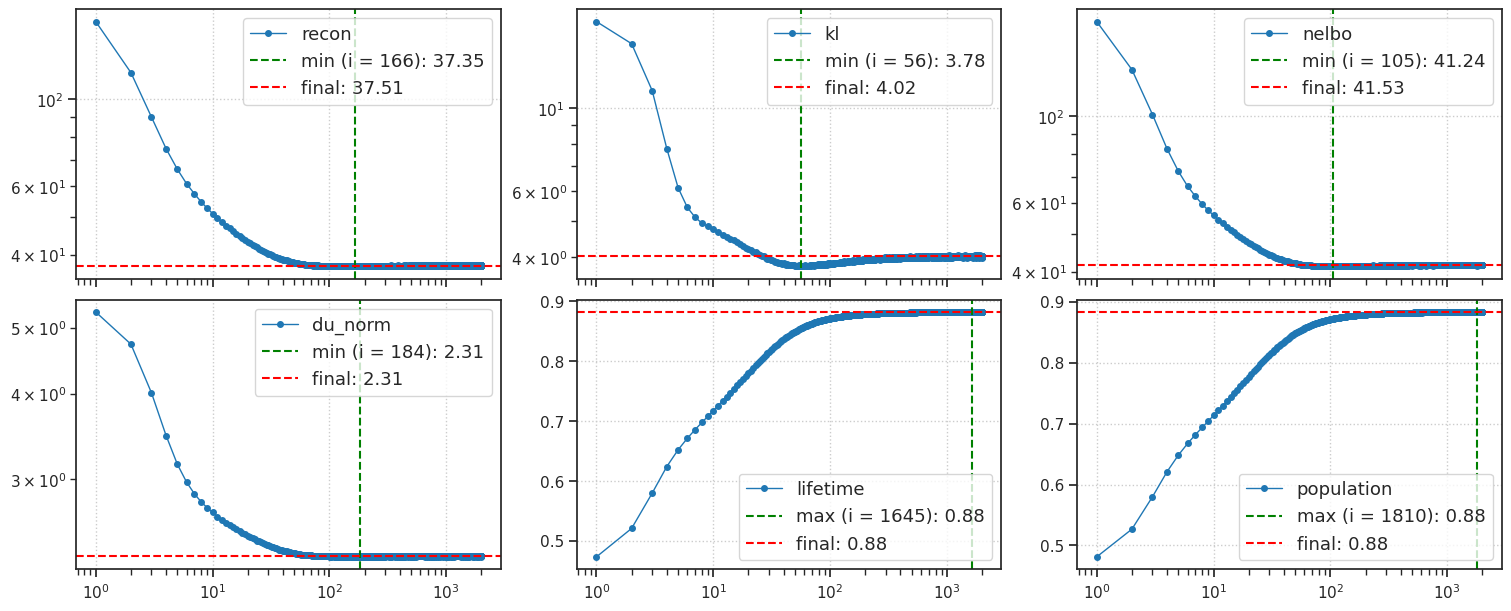

In [15]:
## Was: beta = 3.0

## Now a $T = 1$ model (PVAE)

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jac|lin')

cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 1

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 1800
cfg_tr['batch_size'] = 500
cfg_tr['kl_beta'] = 1.0
cfg_tr['kl_balancer'] = None

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'enc_type': 'jac', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.01, 'seq_len': 1}

Trainer:
{'batch_size': 500, 'epochs': 1800, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 'kl_const_portion': 
0.0, 'lr': 0.002, 'kl_beta': 1.0, 'kl_balancer': None}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  132.1 K   |
|     ———     |    ———     |
|  layers.L_0 |  132.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-1_z-[512]_k-32_<jac|lin>
mc_b500-ep1800-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_31,09:54)

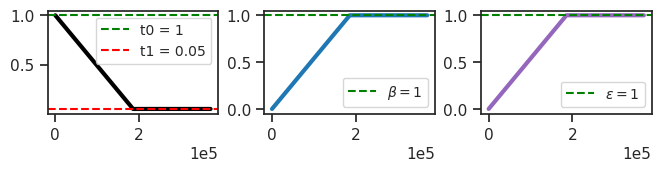

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  132.1 K   |
|     ———      |    ———     |
|    fc_dec    |  131.1 K   |
+--------------+------------+

### Fit model

In [7]:
tr.train(fit_name = f"dMSE_+Bias_bal-{tr.cfg.kl_balancer}_{tr.cfg.name()}")

epoch # 1800, avg loss: 165.714975: 100%|████████████████████████████████████████████████████| 1800/1800 [2:00:06<00:00,  4.00s/it]


In [8]:
print(tr.model.input_layer)

PoissonLayer(dim=512, input_dim=16, temp=0.05, n_exp=24, beta=1, eps=1)

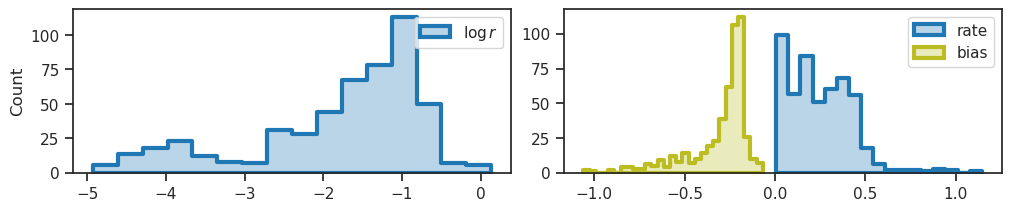

In [14]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
bias = tonp(tr.model.input_layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

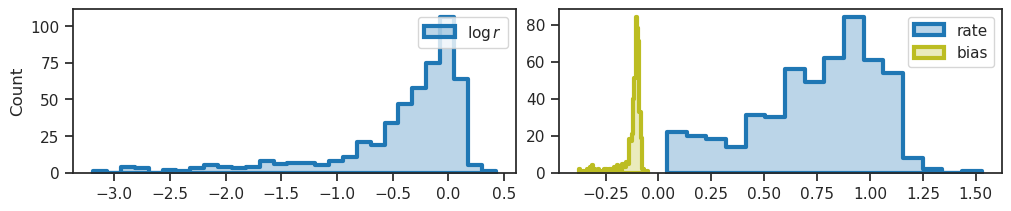

In [9]:
## Was: T = 2

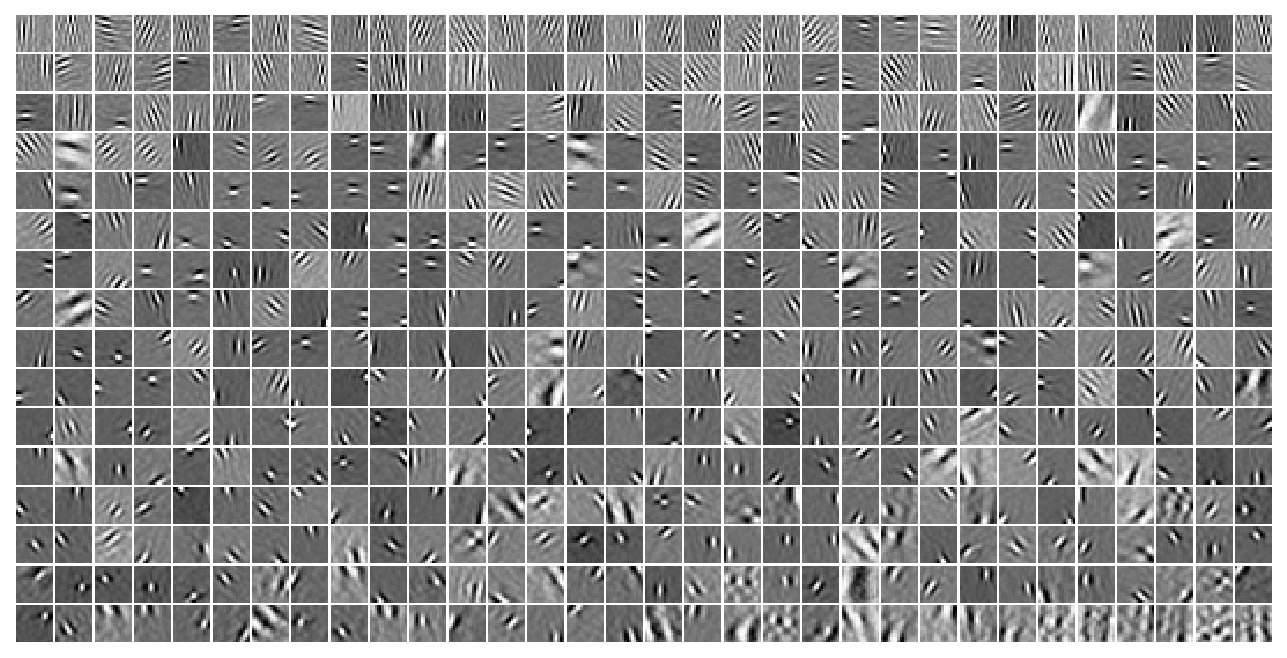

In [15]:
tr.model.show('dec', order=np.argsort(log_rate));

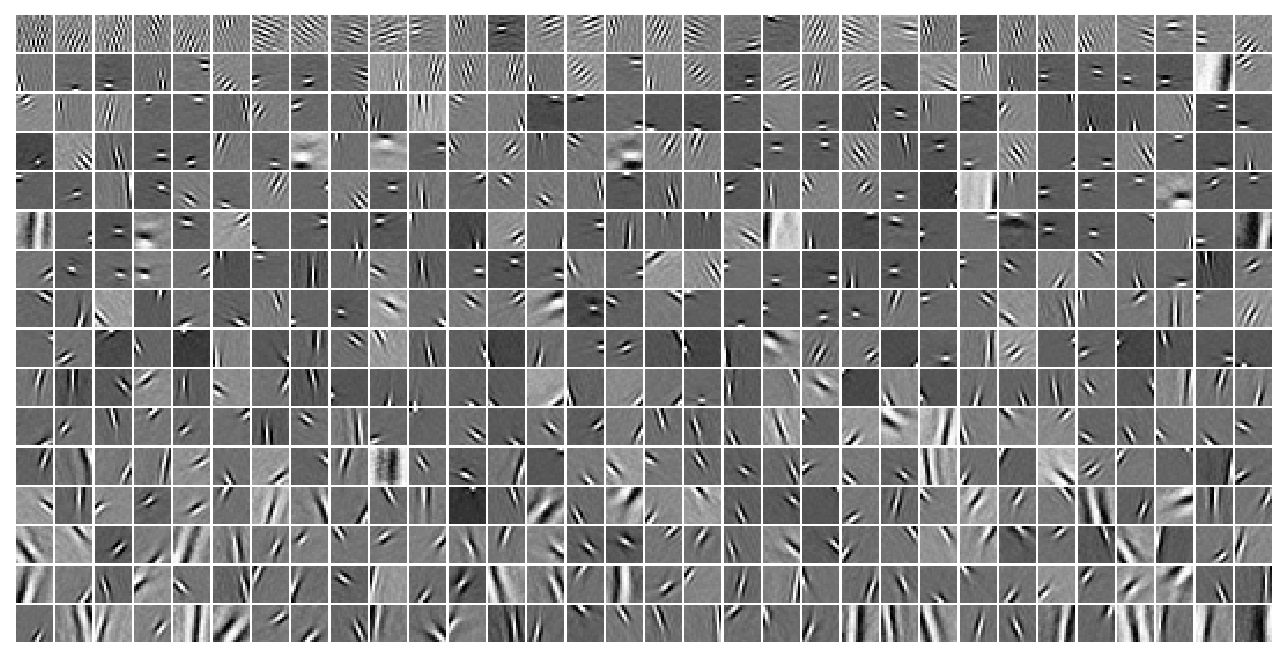

In [13]:
## Was: T = 2

In [11]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{
    'kl': array([29.99169], dtype=float32),
    'recon': array([138.46278], dtype=float32),
    'nelbo': array([168.45448], dtype=float32)
}

In [10]:
## Was: T = 2

{
    'kl': array([27.218367, 20.681807], dtype=float32),
    'recon': array([143.4424  , 106.076515], dtype=float32),
    'nelbo': array([170.6607  , 126.758125], dtype=float32)
}

### Analysis

In [12]:
results = tr.analysis(2000, verbose=True)

100%|█████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]


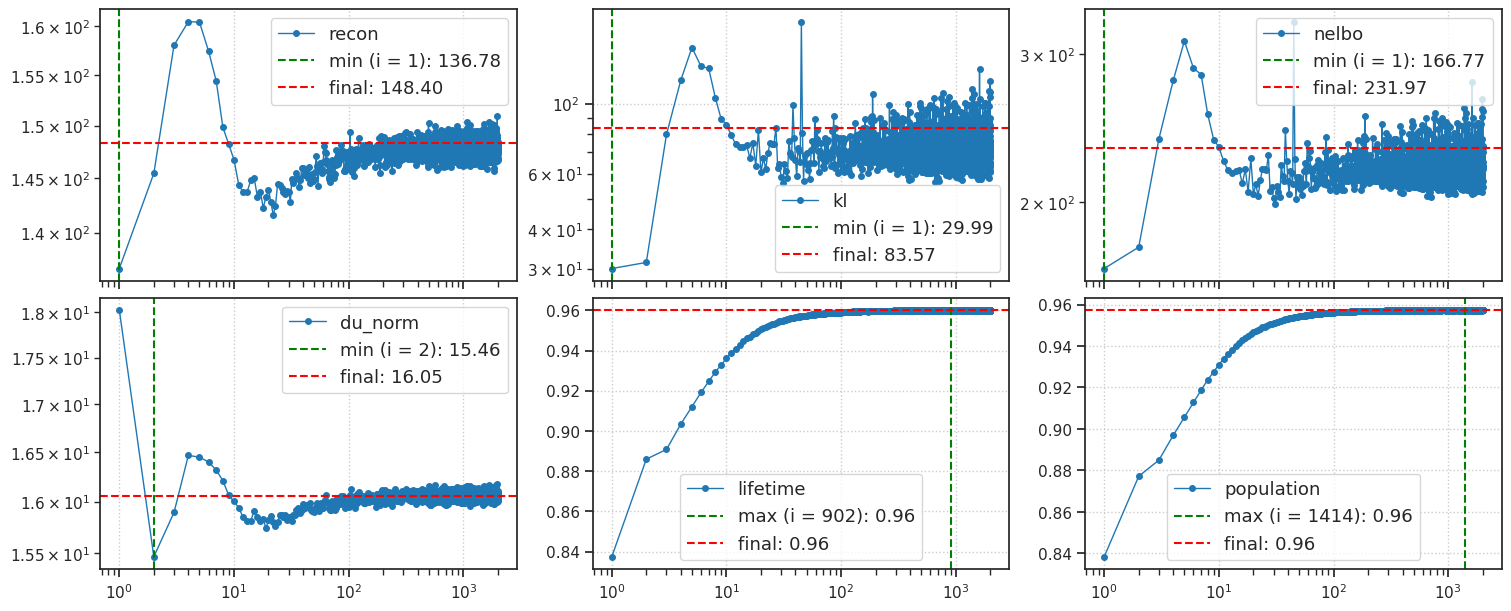

In [13]:
from figures.analysis import plot_convergence
plot_convergence(results)

In [ ]:
s

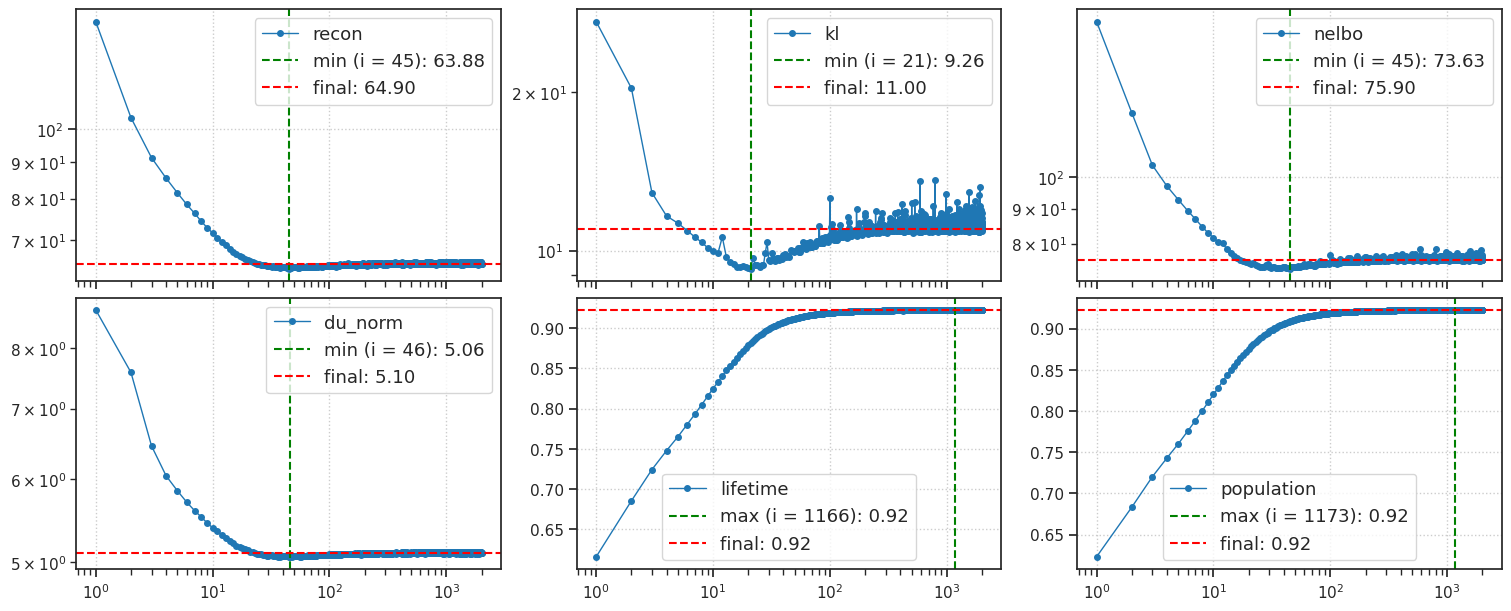

In [12]:
## Was: T = 2